In [1]:
import scipy.optimize

import Modules.SQcircuit_extensions as sq_ext
import Modules.perturbation_theory as pt
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload 
import scipy as sp
from scipy.optimize import curve_fit, minimize

# %matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
reload(sq_ext)
reload(sq)
reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

<Figure size 640x480 with 0 Axes>

In [2]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0  = h/(2*e0)

## Fluxonium, $\phi_{ext} \ne 0.5$

In [3]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)
# C*=1.1;  CJ*=0.912314; Csh*=1.12312; Lq*=0.9874712487; Lr*=1.2414; Δ*=0.8127414; EJ*=1.241432 

In [4]:
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
nmax_f=20

fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5, nmax_f=nmax_f)
H_0  = fluxonium_0.hamiltonian()
E_0 = fluxonium_0.diag(3)[0]

ω_q = sq_ext.diag(H_0,2, solver='numpy', remove_ground=True)[0][1]

In [5]:
N_elements = 1
basis_states = [(0,), (1,)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)

labels_low = [f'({i})' for i in basis_states]
labels_high = [f'({i})' for i in mediating_states]

In [6]:
φ_ext_values = np.linspace(0.5, 1, 100)
n_order=4

In [13]:
Pauli_p1  = np.zeros([len(φ_ext_values),4])
Pauli_p2  = np.zeros([len(φ_ext_values),4])
Pauli_p3  = np.zeros([len(φ_ext_values),4])
Pauli_SWT = np.zeros([len(φ_ext_values),4])

Pauli_p1_pt  = np.zeros([len(φ_ext_values),4])
Pauli_p2_pt  = np.zeros([len(φ_ext_values),4])
Pauli_p3_pt  = np.zeros([len(φ_ext_values),4])

H_eff  = np.zeros([len(φ_ext_values),2,2])

ω_vs_φ_ext     = np.zeros(len(φ_ext_values))
ω_qo_vs_φ_ext  = np.zeros(len(φ_ext_values))

H_eff_terms_vs_φ_ext = np.zeros([len(φ_ext_values), n_order+1,2,2], dtype='complex')

for i, φ_ext  in enumerate(φ_ext_values):
    fluxonium   = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f)
    H    = fluxonium.hamiltonian()
    ω_vs_φ_ext[i] = sq_ext.diag(H, 2, solver='numpy', remove_ground=True)[0][1]
    
    Pauli_p1[i,:], Pauli_p2[i,:], Pauli_p3[i,:], Pauli_SWT[i,:], H_eff_decomp, H_eff[i,:] = sq_ext.H_eff_2x2([H_0], H, basis_states, mediating_states, n_eig=len(basis_states)+len(mediating_states), return_decomposition=True, return_H_eff=True)
    
    # _, H_eff_terms_vs_φ_ext[i,:] = pt.perturbation_H_eff(H_0.__array__()/(2*np.pi*GHz), (H-H_0).__array__()/(2*np.pi*GHz), n_low=2, n_order=n_order)

C:\Users\gabri\AppData\Local\Temp\ipykernel_20452\97539330.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  Pauli_p1[i,:], Pauli_p2[i,:], Pauli_p3[i,:], Pauli_SWT[i,:], H_eff_decomp, H_eff[i,:] = sq_ext.H_eff_2x2([H_0], H, basis_states, mediating_states, n_eig=len(basis_states)+len(mediating_states), return_decomposition=True, return_H_eff=True)


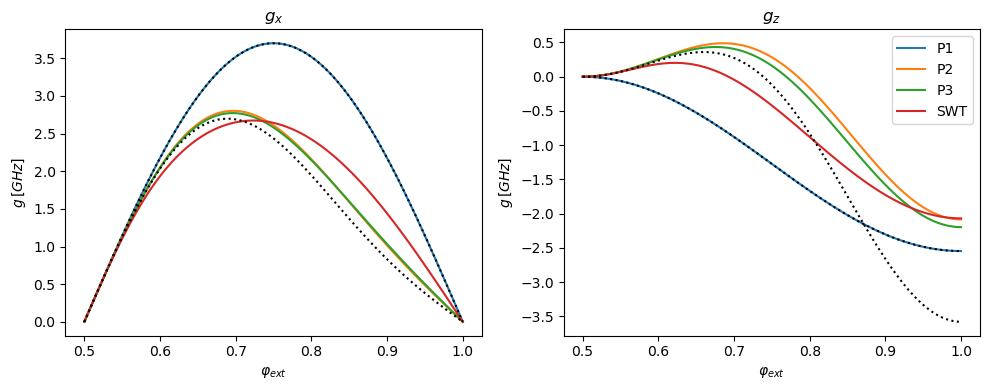

In [14]:
titles = ['I', 'σx', 'σy', 'σz']

Pauli_decomp_list = [ Pauli_p1, Pauli_p2, Pauli_p3, Pauli_SWT]
markers= ['.', 'o','s', '*']
labels = ['P1', 'P2', 'P3', 'SWT']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = [10,4])

for i, Pauli_decomp in enumerate(Pauli_decomp_list):
    ax1.plot(φ_ext_values, Pauli_decomp[:,1] , label=labels[i] ) 
    ax2.plot(φ_ext_values, Pauli_decomp[:,-1]+ω_q/2, label=labels[i] ) 

# for n in range(2, n_order+2):
#     H_eff=0
#     for N in range(n):
#         H_eff += H_eff_terms_vs_φ_ext[:,N,:,:]
#     Pauli_decomp_n = np.zeros([len(φ_ext_values),4])
#     for j in range(len(φ_ext_values)):
#         Pauli_decomp_n[j] = sq_ext.decomposition_in_pauli_2x2(H_eff[j,:])  
#     ax1.plot(φ_ext_values, Pauli_decomp_n[:,1],':', label=n-1, linewidth=3 ) 
#     ax2.plot(φ_ext_values, Pauli_decomp_n[:,-1]+ω_q/2, ':',label=n-1, linewidth=3 ) 

gx_p1, gz_p1, gx_p2, gz_p2 = sq_ext.fluxonium_qubit_ops_vs_φ_ext(EJ, E_0, fluxonium_0, φ_ext_values, return_full=True)

ax1.plot(φ_ext_values, gx_p1 , ':k')
ax2.plot(φ_ext_values, gz_p1 , ':k' )

ax1.plot(φ_ext_values, gx_p1 + gx_p2, ':k')
ax2.plot(φ_ext_values, gz_p1 + gz_p2, ':k' )

ax2.legend()

ax1.set_title(r'$g_x$')
ax2.set_title(r'$g_z$')
[ax.set_ylabel(r'$g\,[GHz]$') for ax in [ax1, ax2]]
[ax.set_xlabel(r'$\varphi_{ext}$') for ax in [ax1, ax2]]

fig.tight_layout()
# fig.show()

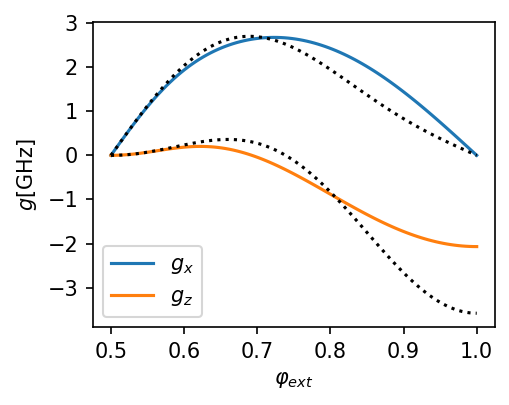

In [20]:

δφ_ext = (φ_ext_values-0.5)


fig, ax = plt.subplots(dpi=150, figsize=np.array([5,4])*0.7)

ax .plot(φ_ext_values, Pauli_SWT[:,1], label='$g_x$' ) 
ax .plot(φ_ext_values, Pauli_SWT[:,-1]+ω_q/2, label='$g_z$' ) 
    
ax .plot(φ_ext_values, gx_p1 + gx_p2, ':k')
ax .plot(φ_ext_values, gz_p1 + gz_p2, ':k')

ax.legend()
ax.set_xlabel(r'$\varphi_{ext}$')
ax.set_ylabel(r'$g$[GHz]')


fig.tight_layout()
# figs.export('fluxonium_vs_phi_ext.pdf',fig) 7

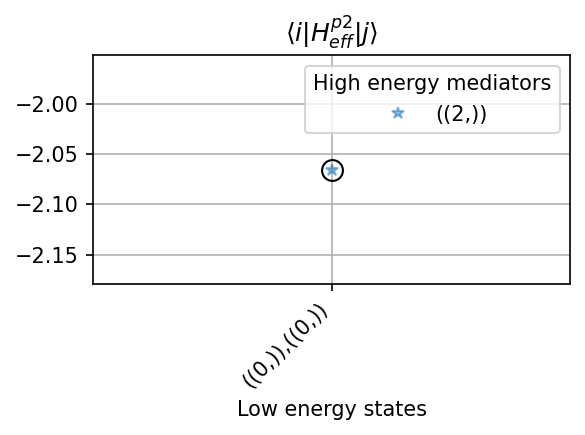

In [10]:
sq_ext.plot_second_order_contributions(H_eff_decomp,labels_low, labels_high, figsize=[4,3])

In [11]:
ω_qo_vs_φ_ext  = np.zeros(len(φ_ext_values))
H_qo_φ_ext  = np.zeros([len(φ_ext_values),2,2], dtype='complex')
for i, φ_ext  in enumerate(φ_ext_values):
    gx_p1, gz_p1, gx_p2, gz_p2 = sq_ext.fluxonium_qubit_ops_vs_φ_ext(EJ, E_0, fluxonium_0, φ_ext)
    gx = gx_p1 + gx_p2
    gz = gz_p1 + gz_p2
    H_qo_φ_ext[i] = sq_ext.hamiltonian_fluxonium_low_ene(ω_q, gx, gz)
    ω_qo_vs_φ_ext[i] = sq_ext.diag(H_qo_φ_ext[i], 2, solver='numpy', remove_ground=True, out='None')[0][1]

In [17]:
reload(sq_ext)
μ = np.real(gx/np.sin(2*np.pi*φ_ext_values[-1]))
A=0
B=1
C=0
bounds =([ω_q-1e-14, -np.inf, -np.inf, -np.inf, -np.inf],[ω_q, np.inf, np.inf, np.inf, np.inf])
ω_q_fit, μ_fit, A_fit, B_fit, C_fit = curve_fit(sq_ext.gap_fluxonium_low_ene_fit, φ_ext_values, ω_vs_φ_ext, [ω_q, μ, A, B, C],bounds=bounds)[0]
ω_q_fit_vs_φ_ext = sq_ext.gap_fluxonium_low_ene_fit(φ_ext_values,ω_q_fit, μ_fit,A_fit, B_fit, C_fit)

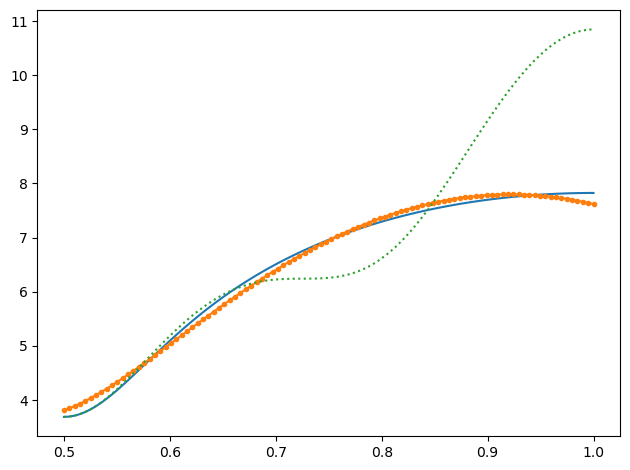

In [18]:
fig, ax = plt.subplots()

ax.plot(φ_ext_values, ω_vs_φ_ext)
ax.plot(φ_ext_values, ω_q_fit_vs_φ_ext,'.-')
ax.plot(φ_ext_values, ω_qo_vs_φ_ext,':')

fig.tight_layout()

## Qubit - Cavity 4x4 effective Hamiltonian - vs Delta  

In [62]:
n_eig  = 5
n_plot = 20
param_name = '\\Delta'
param_values = np.geomspace(1e-5, 8, n_plot)
Δ_values = param_values

N_elements = 2
basis_states = [(0,0), (0,1), (1,0), (1,1)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low = [f'({i},{j})' for i, j in basis_states]
labels_high = [f'({i},{j})' for i, j in mediating_states]

n_eig_extra_low = 2

In [63]:
C, CJ, Csh, Lq, Lr, _, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
φ_ext=0.5

In [66]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
ω_f_0      = np.zeros(len(Δ_values))
ω_r_0      = np.zeros(len(Δ_values))
g_r_limit  = np.zeros(len(Δ_values))
g_fq_limit = np.zeros(len(Δ_values))
g_xx_pert  = np.zeros(len(Δ_values), dtype='complex')
g_zz_pert  = np.zeros(len(Δ_values), dtype='complex')
g_yy_pert  = np.zeros(len(Δ_values), dtype='complex')
X          = np.zeros(len(Δ_values), dtype='complex')
E_low_vs_Δ = np.zeros([len(Δ_values),4])


for i, Δ in enumerate(Δ_values):
    C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
    L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
    
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=φ_ext)
    resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ)
    
    H_0, H   = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff, return_H_0=True)
    
    Hf = fluxonium.hamiltonian()
    Hr = resonator.hamiltonian()
    
    P1, P2, SWT = sq_ext.H_eff_4x4([Hf,Hr], H, basis_states, mediating_states, n_eig=5, return_decomposition=False)
    
    Pauli_p1 .append(P1)
    Pauli_p2 .append(P2)
    Pauli_SWT.append(SWT)
 
    fluxonium.diag(3);
    resonator.diag(3);
    omega_f  = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    omega_f2 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
    omega_r  = resonator.efreqs[1]-resonator.efreqs[0]
    
    Φ_f = fluxonium.flux_op(0, basis='eig')
    Φ_r = resonator.flux_op(0, basis='eig')
    g_xx_pert[i] = 1 / (L_C_eff*nH)  *  (Φ_f[0,1]*Φ_r[0,1]/(2*np.pi*GHz)) 
    g_zz_pert[i] =   ( (1 / (L_C_eff*nH) )**2   * ( 
                    Φ_r[1,2]**2 * Φ_f[0,1]**2/(+omega_r +omega_f  ) +
                    Φ_r[0,1]**2 * Φ_f[1,2]**2/(+omega_r +omega_f2 ) +
                    Φ_r[1,2]**2 * Φ_f[1,2]**2/(-omega_r -omega_f2 ) +
                    Φ_r[1,2]**2 * Φ_f[0,1]**2/(-omega_r +omega_f  ) +
                    Φ_r[0,1]**2 * Φ_f[1,2]**2/(+omega_r -omega_f2 )  
                     )/ (2*np.pi*GHz)**2) / 4
    
    # X[i] =  -2*g_zz_pert[i] + g_xx_pert[i]**2 * ((omega_f-omega_r)**-1 + (omega_f+omega_r)**-1)
    X[i] =  -4*g_zz_pert[i] 
    # X[i] =  g_xx_pert[i]**2 * ((omega_f-omega_r)**-1 + (omega_f+omega_r)**-1)
    ω_f_0[i] = omega_f
    ω_r_0[i] = omega_r
    
    # Analytic estimation of coupling
    E_L_f = sq_ext.L_to_EL(L_F_eff)
    V_fluxonium =  lambda φ: E_L_f*φ**2/2 - EJ*GHz*np.cos(φ+np.pi)
    φ_min = sp.optimize.minimize_scalar(V_fluxonium).x
    
    Φ_f_fq_limit_01 = (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    Φ_f_r_limit_01  = np.sqrt(0.5*np.sqrt((L_F_eff * nH)/(C_F_eff * fF)))
    Φ_r_01 = np.sqrt(0.5*np.sqrt((L_R_eff * nH)/(C_R_eff * fF)))
    
    g_fq_limit[i] = 1/(L_C_eff * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    g_r_limit[i] =  1/(L_C_eff * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz
    
Pauli_p1  = np.array(Pauli_p1)
Pauli_p2  = np.array(Pauli_p2)
Pauli_SWT = np.array(Pauli_SWT)

C:\Users\gabri\AppData\Local\Temp\ipykernel_23212\2038207065.py:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(L_C_eff_values[::4]**-1, g_xx_pert[::4] * 1e3, '*', color = colors[0], marker='o', markersize='4')
C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\gabri\AppData\Local\Temp\ipykernel_23212\2038207065.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(L_C_eff_values[::4]**-1, g_zz_pert[::4] * 1e3, '*', color = colors[2], marker='o', markersize='4')


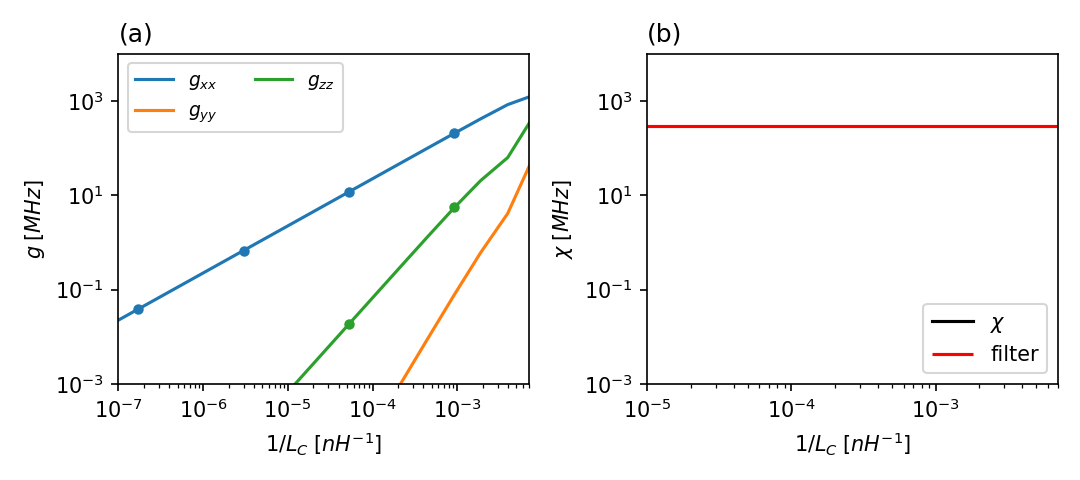

In [67]:
fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize =np.array([9,4])*0.8, dpi=150)
linestyles = ['-', '--','-' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True

L_C_eff_values = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ_values)[-1]

for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    if i==0 or i==1:
        continue

    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])

    ax1.plot(L_C_eff_values**-1, σxσx * 1e3, color = colors[0], linestyle=linestyles[i], label = r'$g_{xx}$')
    ax1.plot(L_C_eff_values**-1, σyσy * 1e3, color = colors[1], linestyle=linestyles[i], label = r'$g_{yy}$')
    ax1.plot(L_C_eff_values**-1, σzσz * 1e3, color = colors[2], linestyle=linestyles[i], label = r'$g_{zz}$')

    # ax1.plot(Δ_values, g_fq_limit, 'x', color = colors[0], label = 'g_{xx}, fluxon', markersize='2')
    # ax1.plot(Δ_values, g_r_limit , 's', color = colors[0], label = 'g_{xx}, plasmon', markersize='2')
    ax1.plot(L_C_eff_values[::4]**-1, g_xx_pert[::4] * 1e3, '*', color = colors[0], marker='o', markersize='4')
    ax1.plot(L_C_eff_values[::4]**-1, g_zz_pert[::4] * 1e3, '*', color = colors[2], marker='o', markersize='4')

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-3,1e4])
ax1.set_xlim([1e-7,7e-3])
ax1.set_ylabel('$g \; [MHz]$')
ax1.set_xlabel('$1/L_C \; [nH^{-1}]$')

E_00 = E_low_vs_Δ[:,0]
E_01 = E_low_vs_Δ[:,1]
E_10 = E_low_vs_Δ[:,2]
E_11 = E_low_vs_Δ[:,3]

X_energies = (E_10-E_00) - (E_11-E_01)

ax2.plot(L_C_eff_values**-1, np.abs(X_energies)*1e3,'k', label='$\chi$')
# ax2.plot(L_C_eff_values[::4]**-1, np.abs(X[::4])*1e3,'.k', label='$\chi$ perturbative')
# ax2.plot(L_C_eff_values[::4]**-1, np.abs(4*g_zz_pert[::4])*1e3,'.k', label='$4g_{zz}$')
 
ax2.hlines(300, 1e-5,7e-3, 'r', label='filter')
 
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim([1e-3,1e4])
ax2.set_xlim([1e-5,7e-3])
ax2.set_ylabel('$\chi\; [MHz]$')
ax2.set_xlabel('$1/L_C \; [nH^{-1}]$')
ax2.legend(loc=4)

ax1.set_title('(a)',loc='left')
ax2.set_title('(b)',loc='left')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
figs.export('g_X_vs_Lc.pdf', fig)
fig.show()

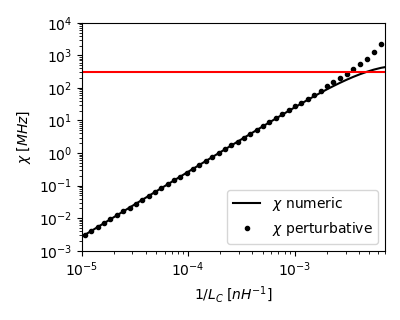

In [166]:
fig, ax = plt.subplots(figsize =np.array([5,4])*0.8, dpi=100)

E_00 = E_low_vs_Δ[:,0]
E_01 = E_low_vs_Δ[:,1]
E_10 = E_low_vs_Δ[:,2]
E_11 = E_low_vs_Δ[:,3]

X_energies = (E_10-E_00) - (E_11-E_01)

ax.plot(L_C_eff_values**-1, np.abs(X_energies)*1e3,'k', label='$\chi$ numeric')
ax.plot(L_C_eff_values**-1, np.abs(X)*1e3,'.k', label='$\chi$ perturbative')

ax.hlines(300, 1e-5,7e-3, 'r')


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-3,1e4])
ax.set_xlim([1e-5,7e-3])
ax.set_ylabel('$\chi\; [MHz]$')
ax.set_xlabel('$1/L_C \; [nH^{-1}]$')
ax.legend(loc=4)

fig.tight_layout()
fig.show()

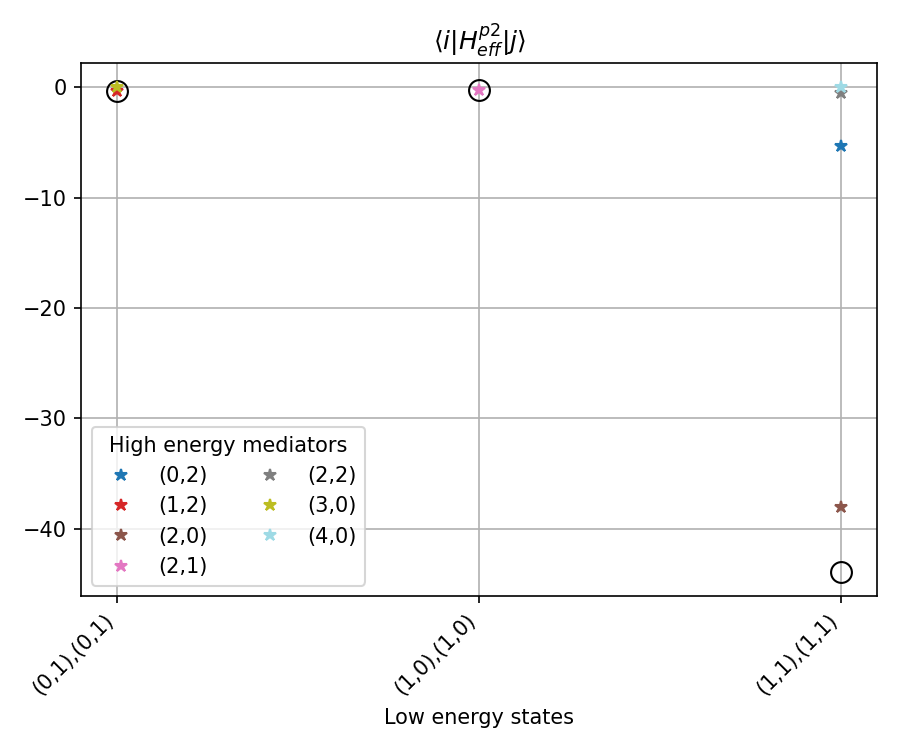

In [145]:
sq_ext.plot_second_order_contributions(H_eff_p2_decomposed, labels_low, labels_high,figsize=np.array([6, 5]) * 1 ,threshold =1e-4)

## Dispersive shift vs n

In [5]:
N_elements = 2
basis_states = []
N = 15
for i in range(N):
    basis_states.append((0,i))
    basis_states.append((1,i))
    
nmax_f = 25
nmax_r = 35
n_eig_H= 150
n_eig_f = 2
n_eig_r = N+10

C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
# Δ=10
φ_ext=0.5

In [6]:
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)

fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f )
resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ, nmax_r=nmax_r )

H_0, H   = sq_ext.hamiltonian_qubit(fluxonium = fluxonium, resonator = resonator, LC=L_C_eff, return_H_0=True)

Hf = fluxonium.hamiltonian()
Hr = resonator.hamiltonian()

ψ0_f         = sq_ext.diag(Hf, n_eig_f, solver='numpy', real=True)[1]
ψ0_r         = sq_ext.diag(Hr, n_eig_r, solver='numpy', real=True)[1]

ψ_0_low = [ qt.tensor(qt.Qobj(ψ0_f[:,i]), qt.Qobj(ψ0_r[:,j]))  for i, j in basis_states]
E_0_ψ_0_low  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_low]

E_0  = sq_ext.diag(H_0  , n_eig=n_eig_H, out='GHz', solver='scipy')[0]
E, ψ = sq_ext.diag(H  , n_eig=n_eig_H, out='GHz', solver='Qutip', qObj=True)

subspace_indices = sq_ext.find_close_indices(E_0_ψ_0_low,E_0)
E_basis_states = E[subspace_indices]

C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:1457: RuntimeWarning: invalid value encountered in divide
  avgz = avgz / np.abs(avgz)


In [11]:
fluxonium.diag(3);
resonator.diag(3);
omega_f  = fluxonium.efreqs[1]-fluxonium.efreqs[0]
omega_f2 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
omega_r  = resonator.efreqs[1]-resonator.efreqs[0]

Φ_f = fluxonium.flux_op(0, basis='eig')
Φ_r = resonator.flux_op(0, basis='eig')
X1       =   ( (1 / (L_C_eff*nH) )**2   * ( 
                Φ_r[1,2]**2 * Φ_f[0,1]**2/(+omega_r +omega_f  ) +
                Φ_r[0,1]**2 * Φ_f[1,2]**2/(+omega_r +omega_f2 ) +
                Φ_r[1,2]**2 * Φ_f[1,2]**2/(-omega_r -omega_f2 ) +
                Φ_r[1,2]**2 * Φ_f[0,1]**2/(-omega_r +omega_f  ) +
                Φ_r[0,1]**2 * Φ_f[1,2]**2/(+omega_r -omega_f2 )  
                 )/ (2*np.pi*GHz)**2)

# X2 = ( (1 / (L_C_eff*nH) )**2   * ( 
#                 Φ_r[0,1]**2 * Φ_f[0,1]**2 * ( 1/(omega_f - omega_r ) + 1/(omega_f + omega_r ) )
#                  )/ (2*np.pi*GHz)**2) * 2

X2 = ( (1 / (L_C_eff*nH) )**2   * ( 
                Φ_r[0,1]**2 * Φ_f[0,1]**2 * ( 1/(omega_f - omega_r ) )
                 )/ (2*np.pi*GHz)**2) 

In [12]:
ω_vs_n = E_basis_states[1::2] - E_basis_states[::2]
X_vs_n = ω_vs_n[1:]-ω_vs_n[0]
n = np.arange(1,N)

C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


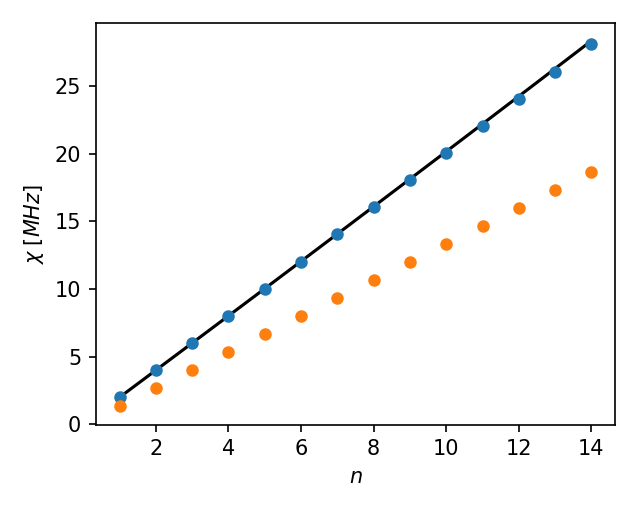

In [13]:
fig, ax = plt.subplots(figsize =np.array([5,4])*0.85, dpi=150)

ax.plot(n,  X_vs_n * 1e3,'k', label='$\chi$')
ax.plot(n,  X1 * n * 1e3,'.', markersize=10, label='')
ax.plot(n, -X2 * n * 1e3,'.', markersize=10)


# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim([1e-3,1e4])
# ax.set_xlim([1e-5,7e-3])
ax.set_ylabel('$\chi\; [MHz]$')
ax.set_xlabel('$n$')

fig.tight_layout()

# figs.export('chi_vs_n.pdf', fig)
fig.show()

## Qubit - Cavity 2xN effective Hamiltonian - vs $\varphi_{ext}$

In [16]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
# L_C_eff = 1e100 

In [41]:
n_eig  = 5

nmax_f=15
nmax_r=10

# basis_states = []
# N = 2
# for i in range(N):
#     basis_states.append((0,i))
#     basis_states.append((1,i))

# basis_states = []
# N = 2
# for q in [0,1]:
#     for n in range(N):
#         basis_states.append((q, n))

basis_states = []
N = 2
for n in range(N):
    for q in [0,1]:
        basis_states.append((q, n))

N_elements = 2
max_excitations_mediating_states = 1
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)

labels_low = [f'({i},{j})' for i, j in basis_states]
labels_low
# labels_high = [f'({i},{j})' for i, j in mediating_states]

['(0,0)', '(1,0)', '(0,1)', '(1,1)']

In [67]:
reload(sq_ext)

n_plot = 50
param_name = '\\varphi_{ext}'
param_values = np.linspace(0.5, 0.51, n_plot)
φ_ext_values = param_values

E_vs_φ_ext = np.zeros([len(φ_ext_values), len(basis_states)]) 
E_quantum_optics_vs_φ_ext = np.zeros([len(φ_ext_values), len(basis_states)]) 
E_full_vs_φ_ext = np.zeros([len(φ_ext_values), n_eig]) 
H_eff_SWT_vs_φ_ext = np.zeros([len(φ_ext_values),len(basis_states),len(basis_states)], dtype='complex')
H_eff_p1_vs_φ_ext = np.zeros([len(φ_ext_values),len(basis_states),len(basis_states)], dtype='complex')

H_eff_decomp_SWT_vs_φ_ext = np.zeros([len(φ_ext_values),len(basis_states),len(basis_states)], dtype='complex')


fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5,nmax_f=nmax_f)
resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ,nmax_r=nmax_r)
Hf = fluxonium_0.hamiltonian()
Hr = resonator.hamiltonian()
H_0_list =[Hf,Hr]

H_0, E_0, ψ_0_basis, ψ_0_mediating = sq_ext.ψ_0_from_H_0(H_0_list, basis_states, mediating_states, n_eig)
E_0_ψ_0_basis = [np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0, 0]) / 2 / np.pi / GHz for ψ_0_i in ψ_0_basis]
subspace_indices = sq_ext.find_close_indices_unique(E_0_ψ_0_basis, E_0)

print(subspace_indices)
for i, φ_ext in enumerate(φ_ext_values):
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff=L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f)
    H = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff )
    
    E, ψ = sq_ext.diag(H, n_eig, out='GHz', solver='Qutip', qObj=True, remove_ground=True)
    # E, ψ = sq_ext.diag(H, n_eig, out='GHz', solver='numpy')
    
    
    E_basis = E[subspace_indices]
    ψ_basis = ψ[subspace_indices]
    
    # if i>0:
    #     if np.abs(E_basis[1]-E_vs_φ_ext[i-1][1]) + np.abs(E_basis[2]-E_vs_φ_ext[i-1][2]) > np.abs(E_basis[1]-E_vs_φ_ext[i-1][2]) + np.abs(E_basis[2]-E_vs_φ_ext[i-1][1]):
    #         aux = subspace_indices[1]
    #         subspace_indices[1] = subspace_indices[2]
    #         subspace_indices[2] = aux
    
    E_full_vs_φ_ext[i] = E
    E_vs_φ_ext[i] = E_basis #-E_basis[0]
    
    H_eff_SWT_vs_φ_ext[i] = sq_ext.H_eff_SWT_large(ψ_0_basis, ψ_basis, E_basis )
    H_eff_p1_vs_φ_ext[i] = sq_ext.H_eff_p1_large(ψ_0_basis, H, out='GHz', real=True, remove_ground=False)
    
    H_eff_decomp_SWT_vs_φ_ext[i] = sq_ext.decomposition_in_pauli_2xN_qubit_resonator(H_eff_SWT_vs_φ_ext[i],print_pretty=False)
   

[0, 1, 2, 4]


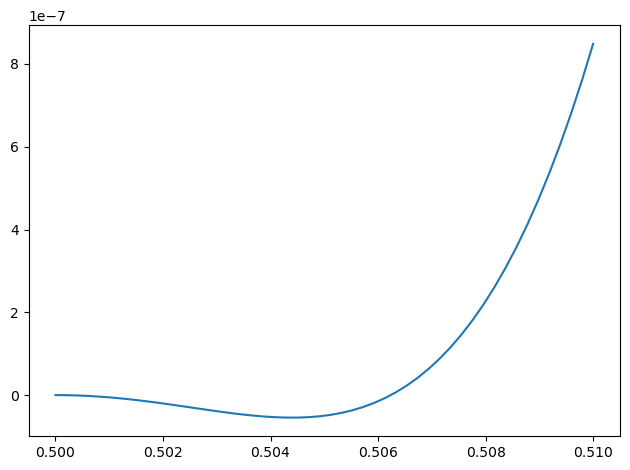

In [68]:
i = 2

fig, ax = plt.subplots()

ax.plot(φ_ext_values, E_vs_φ_ext[:,i]-E_vs_φ_ext[0,i])

fig.tight_layout()

C:\Users\gabri\AppData\Local\Temp\ipykernel_25044\587596296.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


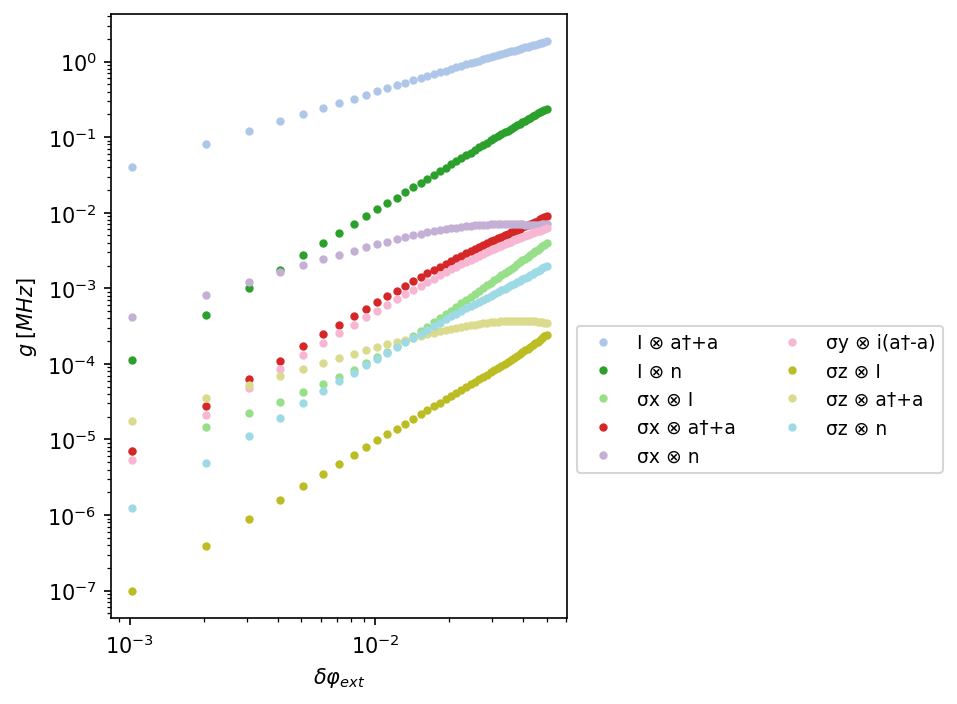

In [64]:
fig, ax1 = plt.subplots( dpi=150)
linestyles = ['-', '--','-' ]
labels = sq_ext.decomposition_in_pauli_2xN_qubit_resonator(H_eff_SWT_vs_φ_ext[i],print_pretty=False, return_labels=True)[1]

colors = figs.generate_colors_from_colormap(16, 'tab20')

H_eff_decomp = H_eff_decomp_SWT_vs_φ_ext.reshape([len(φ_ext_values), 16])

for i in range(16):
        if i==0:
            continue
        if np.any( np.abs(H_eff_decomp[:,i]- H_eff_decomp[0,i]) >1e-12):
            ax1.plot(φ_ext_values-0.5, np.abs(H_eff_decomp[:,i]- H_eff_decomp[0,i]),  '.',color = colors[i], label = labels[i])

ax1.set_yscale('log')
ax1.set_xscale('log')
# ax1.set_ylim([1e-4,1e1])
ax1.set_ylabel('$g \; [MHz]$')
ax1.set_xlabel(r'$\delta\varphi_{ext}$')
# ax1.set_aspect('equal')
ax1.legend(ncol=2, fontsize=9, bbox_to_anchor=(1, 0., 0.5, 0.5))

fig.tight_layout()
fig.show()

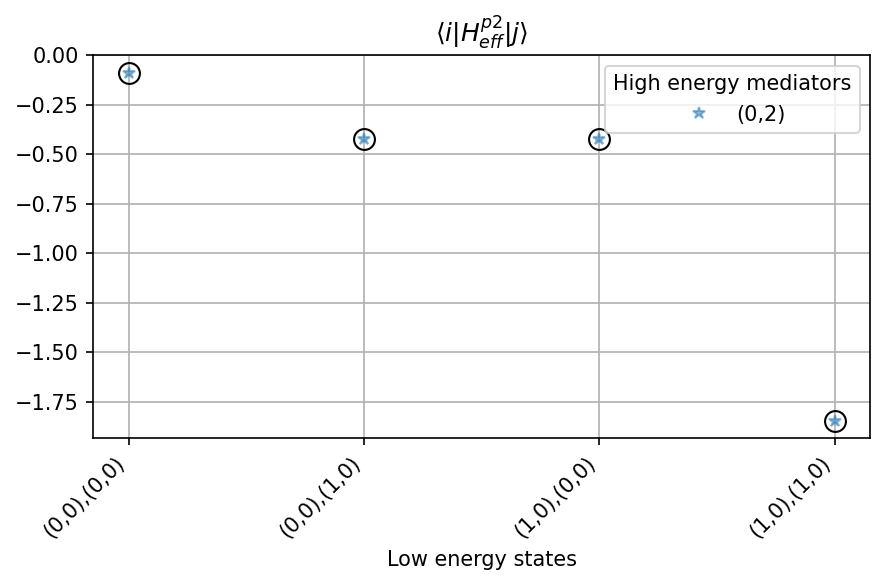

In [37]:
sq_ext.plot_second_order_contributions(H_eff_decomp,labels_low, labels_high, figsize=[6,4], threshold=1e-3)

## Qubit - Cavity 2xN fitted quantum optics Hamiltonian - vs $\varphi_{ext}$

In [69]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
# L_C_eff = 1e100 
# L_C_eff *= 10 
# C_R_eff /=1.8
# C_R_eff *=2.5
# EJ*=2
# C_F_eff*=0.25

In [71]:
fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5, nmax_f=nmax_f)
resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ,nmax_r=nmax_r)
ω_q = sq_ext.diag(fluxonium_0.hamiltonian(), 3, solver='numpy', remove_ground=True)[0][1:3]
ω_r = sq_ext.diag(resonator.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
ω_q, ω_r

(array([3.423359346451, 8.519383264473]), 6.273999999999506)

In [72]:
 n_eig  = 5

nmax_f=15
nmax_r=10

basis_states = []
N = 2
for q in [0,1]:
    for n in range(N):
        basis_states.append((q, n))

N_elements = 2
max_excitations_mediating_states=3
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)

labels_low = [f'({i},{j})' for i, j in basis_states]
labels_low

['(0,0)', '(0,1)', '(1,0)', '(1,1)']

In [73]:
reload(sq_ext)

n_plot = 100
# φ_ext_values = np.linspace(0.5, 0.8, n_plot)
φ_ext_values = np.geomspace(0.5, 0.65, n_plot)

E_vs_φ_ext = np.zeros([len(φ_ext_values), len(basis_states)]) 

E_full_vs_φ_ext = np.zeros([len(φ_ext_values), n_eig]) 
H_eff_SWT_vs_φ_ext = np.zeros([len(φ_ext_values),len(basis_states),len(basis_states)], dtype='complex')

SWT_decomposition_vs_φ_ext = np.zeros([len(φ_ext_values),4,4])
labels_SWT_decomposition_vs_φ_ext = []

fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5, nmax_f=nmax_f)
resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ,nmax_r=nmax_r)
Hf = fluxonium_0.hamiltonian()
Hr = resonator.hamiltonian()
H_0_list =[Hf,Hr]

H_0, E_0, ψ_0_basis, ψ_0_mediating = sq_ext.ψ_0_from_H_0(H_0_list, basis_states, mediating_states, n_eig)
E_0_ψ_0_basis = [np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0, 0]) / 2 / np.pi / GHz for ψ_0_i in ψ_0_basis]
subspace_indices = sq_ext.find_close_indices_unique(E_0_ψ_0_basis, E_0)
print(subspace_indices)


[0, 2, 1, 4]


In [74]:
fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, nmax_f=nmax_f)
loop = fluxonium.loops[0]
for i, φ_ext in enumerate(φ_ext_values):
    loop.set_flux(φ_ext)
    H = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff )
    
    E, ψ = sq_ext.diag(H, n_eig, out='GHz', solver='Qutip', qObj=True, remove_ground=True)
    
    ψ_basis = ψ[subspace_indices]
    E_basis = E[subspace_indices]
    
    E_full_vs_φ_ext[i] = E
    E_vs_φ_ext[i] = np.sort(E_basis)
    
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0_basis,ψ_basis, E_basis )
    SWT_decomposition_vs_φ_ext[i], labels_SWT_decomposition_vs_φ_ext = sq_ext.decomposition_in_pauli_2xN_qubit_resonator(H_eff_SWT, print_pretty=False,return_labels=True)

C:\Users\gabri\AppData\Local\Temp\ipykernel_25044\116805540.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  SWT_decomposition_vs_φ_ext[i], labels_SWT_decomposition_vs_φ_ext = sq_ext.decomposition_in_pauli_2xN_qubit_resonator(H_eff_SWT, print_pretty=False,return_labels=True)


In [103]:
reload(sq_ext)

<module 'Modules.SQcircuit_extensions' from 'C:\\Users\\gabri\\PycharmProjects\\tunable-capacitive-coupling-flux-qubits\\Modules\\SQcircuit_extensions.py'>

In [104]:
g_Φ = sq_ext.get_parameters_QR(fluxonium_0, resonator, L_C_eff)
coefs_vs_φ_ext, E_fitted_vs_φ_ext = sq_ext.fit_QR_Hamiltonian(fluxonium_0, resonator, g_Φ, E_vs_φ_ext, print_progress=True)

Optimization 0, variable = g_x
The final error of optimization 0 is 25.81448070821873 MHz
Optimization 1, variable = g_z
The final error of optimization 1 is 25.814480391974545 MHz


In [ ]:
def fit_global_gΦ_QR_vs_φext(g_Φ, fluxonium_0, resonator, E_QR_vs_φ_ext, print_progress=True ):
    
    coefs_vs_φ_ext, E_fitted_vs_φ_ext = sq_ext.fit_QR_Hamiltonian(fluxonium_0, resonator, g_Φ, E_QR_vs_φ_ext, print_progress)
    error_vs_φ_ext = np.abs(E_fitted_vs_φ_ext-E_QR_vs_φ_ext)
    
    if print_progress:
        print(f'\n The total error for g_Φ = {g_Φ} is {np.sum(error_vs_φ_ext)} \n')
    return np.sum(error_vs_φ_ext)


In [106]:
fit_global_gΦ_QR_vs_φext(g_Φ, fluxonium_0, resonator, E_vs_φ_ext, True)

Optimization 0, variable = g_x
The final error of optimization 0 is 25.81448070821873 MHz
Optimization 1, variable = g_z
The final error of optimization 1 is 25.814480391974545 MHz

 The total error for g_Φ = 0.061681130360634856 is 31.115942376125048 


31.115942376125048

In [107]:

g_Φ = sq_ext.get_parameters_QR(fluxonium_0, resonator, L_C_eff)
g_Φ_opt = minimize(fit_global_gΦ_QR_vs_φext,  [g_Φ], (fluxonium_0, resonator, E_vs_φ_ext, True)) 
g_Φ, g_Φ_opt.x


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [204]:
coefs_vs_φ_ext, E_fitted_vs_φ_ext = sq_ext.fit_QR_Hamiltonian(fluxonium_0, resonator, g_Φ_opt.x, E_vs_φ_ext, print_progress=True)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

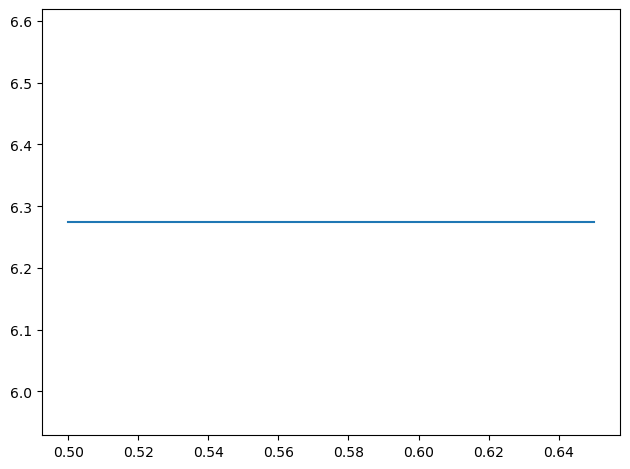

In [93]:
fig, ax = plt.subplots()

ax.plot(φ_ext_values, coefs_vs_φ_ext[:,3])

fig.tight_layout()

In [160]:
error_fitted_vs_φ_ext = np.sum(np.abs(E_fitted_vs_φ_ext[:,:3] - E_vs_φ_ext[:,:3]),1)

In [146]:
reload(sq_ext)

E_p1_vs_φ_ext               = np.zeros([len(φ_ext_values), len(basis_states)]) 
E_p2_vs_φ_ext               = np.zeros([len(φ_ext_values), len(basis_states)]) 
E_SWT_vs_φ_ext              = np.zeros([len(φ_ext_values), len(basis_states)]) 
E_SWT_gΦ_global_vs_φ_ext    = np.zeros([len(φ_ext_values), len(basis_states)])

error_p1_vs_φ_ext               = np.zeros(len(φ_ext_values)) 
error_p2_vs_φ_ext               = np.zeros(len(φ_ext_values)) 
error_SWT_vs_φ_ext              = np.zeros(len(φ_ext_values)) 
error_SWT_gΦ_global_vs_φ_ext    = np.zeros(len(φ_ext_values))

ω_q = sq_ext.diag(fluxonium_0.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
ω_r = sq_ext.diag(resonator.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
g_Φ = sq_ext.get_parameters_QR(fluxonium_0, resonator, L_C_eff)
E_0 = fluxonium_0.diag(3)[0]
gx_p1_vs_φ_ext, gz_p1_vs_φ_ext, _, _= sq_ext.fluxonium_qubit_ops_vs_φ_ext(EJ, E_0, fluxonium_0, φ_ext_values)
gx_p2_vs_φ_ext, gz_p2_vs_φ_ext = sq_ext.fluxonium_qubit_ops_vs_φ_ext(EJ, E_0, fluxonium_0, φ_ext_values, return_full=True)

loop = fluxonium.loops[0]
for i, (φ_ext, gx_p1, gz_p1, gx_p2, gz_p2) in enumerate(zip(φ_ext_values, gx_p1_vs_φ_ext,gz_p1_vs_φ_ext,gx_p2_vs_φ_ext,gz_p2_vs_φ_ext)):
    
    loop.set_flux(φ_ext)
    g_SWT = sq_ext.decomposition_in_pauli_2x2(sq_ext.H_eff_SWT(fluxonium_0.hamiltonian(),fluxonium.hamiltonian(),2))
    gx_SWT, gz_SWT = [g_SWT[1],g_SWT[-1]-ω_q/2]
    
    E_p1_vs_φ_ext[i], error_p1_vs_φ_ext[i] = (
        sq_ext.E_fit_QR_low_ene([ω_q, gx_p1, gz_p1], ω_r, g_Φ       , E_vs_φ_ext[i], return_E=True))
    E_p2_vs_φ_ext[i], error_p2_vs_φ_ext[i] = (
        sq_ext.E_fit_QR_low_ene([ω_q, gx_p2, gz_p2], ω_r, g_Φ       , E_vs_φ_ext[i], return_E=True))
    E_SWT_vs_φ_ext[i], error_SWT_vs_φ_ext[i] = (
        sq_ext.E_fit_QR_low_ene([ω_q, gx_SWT, gz_SWT], ω_r, g_Φ     , E_vs_φ_ext[i], return_E=True))
    E_SWT_gΦ_global_vs_φ_ext[i], error_SWT_gΦ_global_vs_φ_ext[i] = (
        sq_ext.E_fit_QR_low_ene([ω_q, gx_SWT, gz_SWT], ω_r, g_Φ_opt.x, E_vs_φ_ext[i], return_E=True))
    
    g_φ_ext = sq_ext.decomposition_in_pauli_2x2(sq_ext.H_eff_SWT(fluxonium_0.hamiltonian(),fluxonium.hamiltonian(),2))
    gx, gz = [g_φ_ext[1],g_φ_ext[-1]-ω_q/2]
    
print(np.sum(error_p1_vs_φ_ext),np.sum(error_p2_vs_φ_ext),np.sum(error_SWT_vs_φ_ext),np.sum(error_SWT_gΦ_global_vs_φ_ext))   

71.61713661013117 67.7572263652435 0.33281313511592137 3.007267393663102


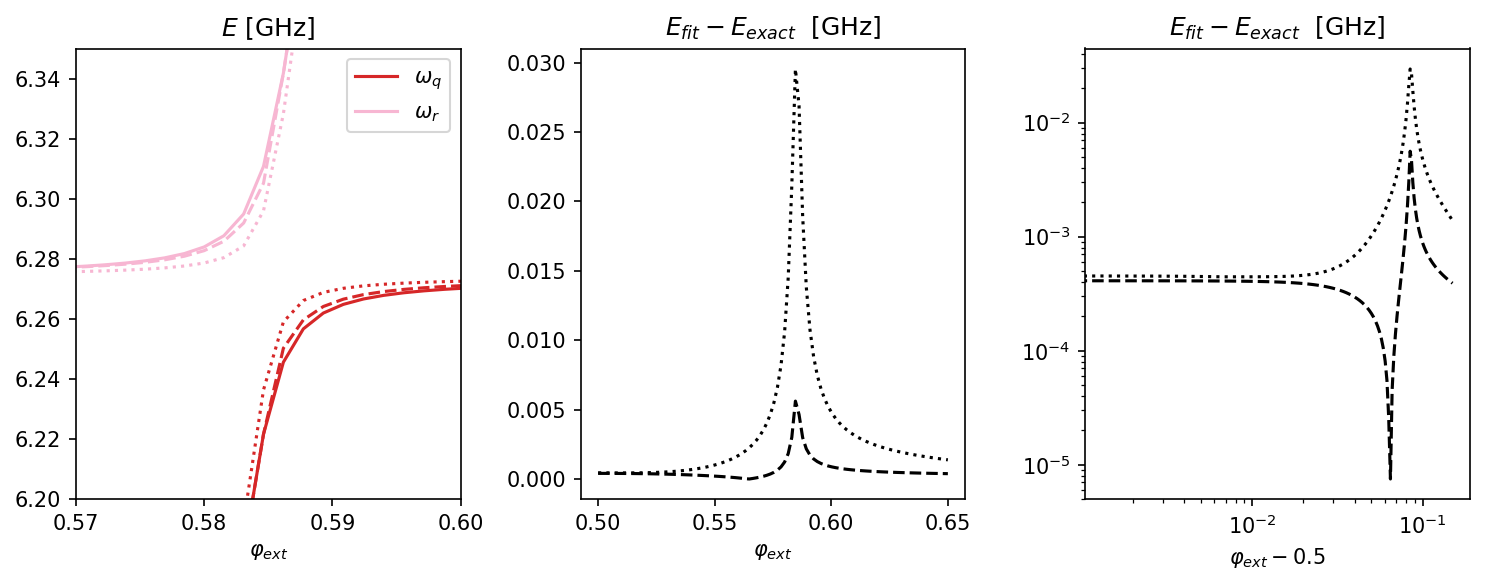

In [165]:
colors = figs.generate_colors_from_colormap(4, 'tab20')
labels_coefs = ['ω_q', 'g_x', 'g_z', 'ω_r', 'g_Φ']
linestyles = []
# fig, (ax1, ax2, ax3, ax4 ) = plt.subplots(ncols=4, figsize = [12,4], dpi=150)
fig, (ax1, ax2, ax3 ) = plt.subplots(ncols=3, figsize = [10,4], dpi=150)

labels_E = ['',r'$\omega_q$',r'$\omega_r$']
for i in range(1,3):
    # ax1.plot(φ_ext_values    , E_p1_vs_φ_ext           [:,i],'o',  color=colors[i], linestyle=None,markersize=2 )
    # ax1.plot(φ_ext_values    , E_p2_vs_φ_ext           [:,i],'v',  color=colors[i], linestyle=N one,markersize=2 )
    ax1.plot(φ_ext_values    , E_vs_φ_ext[:,i], color=colors[i], label=labels_E[i]) 
    ax1.plot(φ_ext_values    , E_SWT_vs_φ_ext          [:,i],':',  color=colors[i]  )
    ax1.plot(φ_ext_values    , E_fitted_vs_φ_ext[:,i],'--', color=colors[i]) 
    # ax1.plot(φ_ext_values    , E_SWT_gΦ_global_vs_φ_ext[:,i],'--',  color=colors[i] )

    
    # ax2.plot(φ_ext_values, np.abs(E_vs_φ_ext[:,i]-E_SWT_vs_φ_ext[:,i])    ,'o',  color=colors[i], linestyle=None,markersize=2 )
    # ax3.plot(φ_ext_values-0.5, np.abs(E_vs_φ_ext[:,i]-E_SWT_vs_φ_ext[:,i]),'v',  color=colors[i], linestyle=None,markersize=2 )
    # 
    # ax2.plot(φ_ext_values, np.abs(E_vs_φ_ext[:,i]-E_SWT_gΦ_global_vs_φ_ext[:,i])  ,'o',  color=colors[i], linestyle=None,markersize=2 )
    # ax3.plot(φ_ext_values-0.5, np.abs(E_vs_φ_ext[:,i]-E_SWT_gΦ_global_vs_φ_ext[:,i]),'v', color=colors[i], linestyle=None,markersize=2 )

ax2.plot(φ_ext_values, error_SWT_vs_φ_ext     ,':k' )
ax3.plot(φ_ext_values-0.5, error_SWT_vs_φ_ext ,':k' )

ax2.plot(φ_ext_values, error_fitted_vs_φ_ext     ,'--k'  )
ax3.plot(φ_ext_values-0.5, error_fitted_vs_φ_ext ,'--k'  )

# ax2.plot(φ_ext_values, error_SWT_gΦ_global_vs_φ_ext     ,'--k'  )
# ax3.plot(φ_ext_values-0.5, error_SWT_gΦ_global_vs_φ_ext ,'--k'  )

ax1.set_ylim([6.2, 6.35])
ax1.set_xlim([0.57,0.6])
ax1.set_xlabel(r'$\varphi_{ext}$')
ax1.set_title(r'$E$ [GHz]')
ax1.legend()

ax2.set_xlabel(r'$\varphi_{ext}$')
ax2.set_title(r'$E_{fit}-E_{exact}$  [GHz]')

ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel(r'$\varphi_{ext}-0.5$')
ax3.set_title(r'$E_{fit}-E_{exact}$  [GHz]')

fig.tight_layout()

# Error vs $\alpha_{qr}$ and $g$

In [110]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
L_C_eff_values = np.geomspace(L_C_eff*10, L_C_eff/10, 6)
C_R_eff_values = np.linspace(C_R_eff*3, C_R_eff/1.5, 6)
φ_ext_values   = np.linspace(0.5, 0.65, 100)

## SWT

In [111]:
max_error = []
α_qr = np.zeros(len(C_R_eff_values))
g = np.zeros(len(C_R_eff_values))
for k, C_R_eff_k in enumerate(C_R_eff_values):
    print(k)
    fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5, nmax_f=nmax_f)
    resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff_k, Δ=Δ, nmax_r=nmax_r)
    ω_q = sq_ext.diag(fluxonium_0.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
    ω_r = sq_ext.diag(resonator.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
    α_qr[k] = ω_r-ω_q
    for j, L_C_eff_j in enumerate(L_C_eff_values):
        g_Φ = sq_ext.get_parameters_QR(fluxonium_0, resonator, L_C_eff_j)
        error_vs_φ_ext = np.zeros(len( φ_ext_values  ))
        for i, φ_ext in enumerate(φ_ext_values):
            fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff=L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f)
            H = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff_j )
            E_exact = sq_ext.diag(H, 3, out='GHz', solver='Qutip', qObj=True, remove_ground=True)[0]
            
            g_φ_ext = sq_ext.decomposition_in_pauli_2x2(sq_ext.H_eff_SWT(fluxonium_0.hamiltonian(),fluxonium.hamiltonian(),2))
            gx, gz = [g_φ_ext[1],g_φ_ext[-1]-ω_q/2]
            
            coefs = [ω_q, gx, gz, ω_r, g_Φ]
            error_vs_φ_ext[i] = sq_ext.E_fit_QR_low_ene(coefs, E_exact)
            
        max_error.append(error_vs_φ_ext.max())
    
max_error = np.array(max_error).reshape([len(C_R_eff_values), len(L_C_eff_values)])



0
1
2
3
4
5


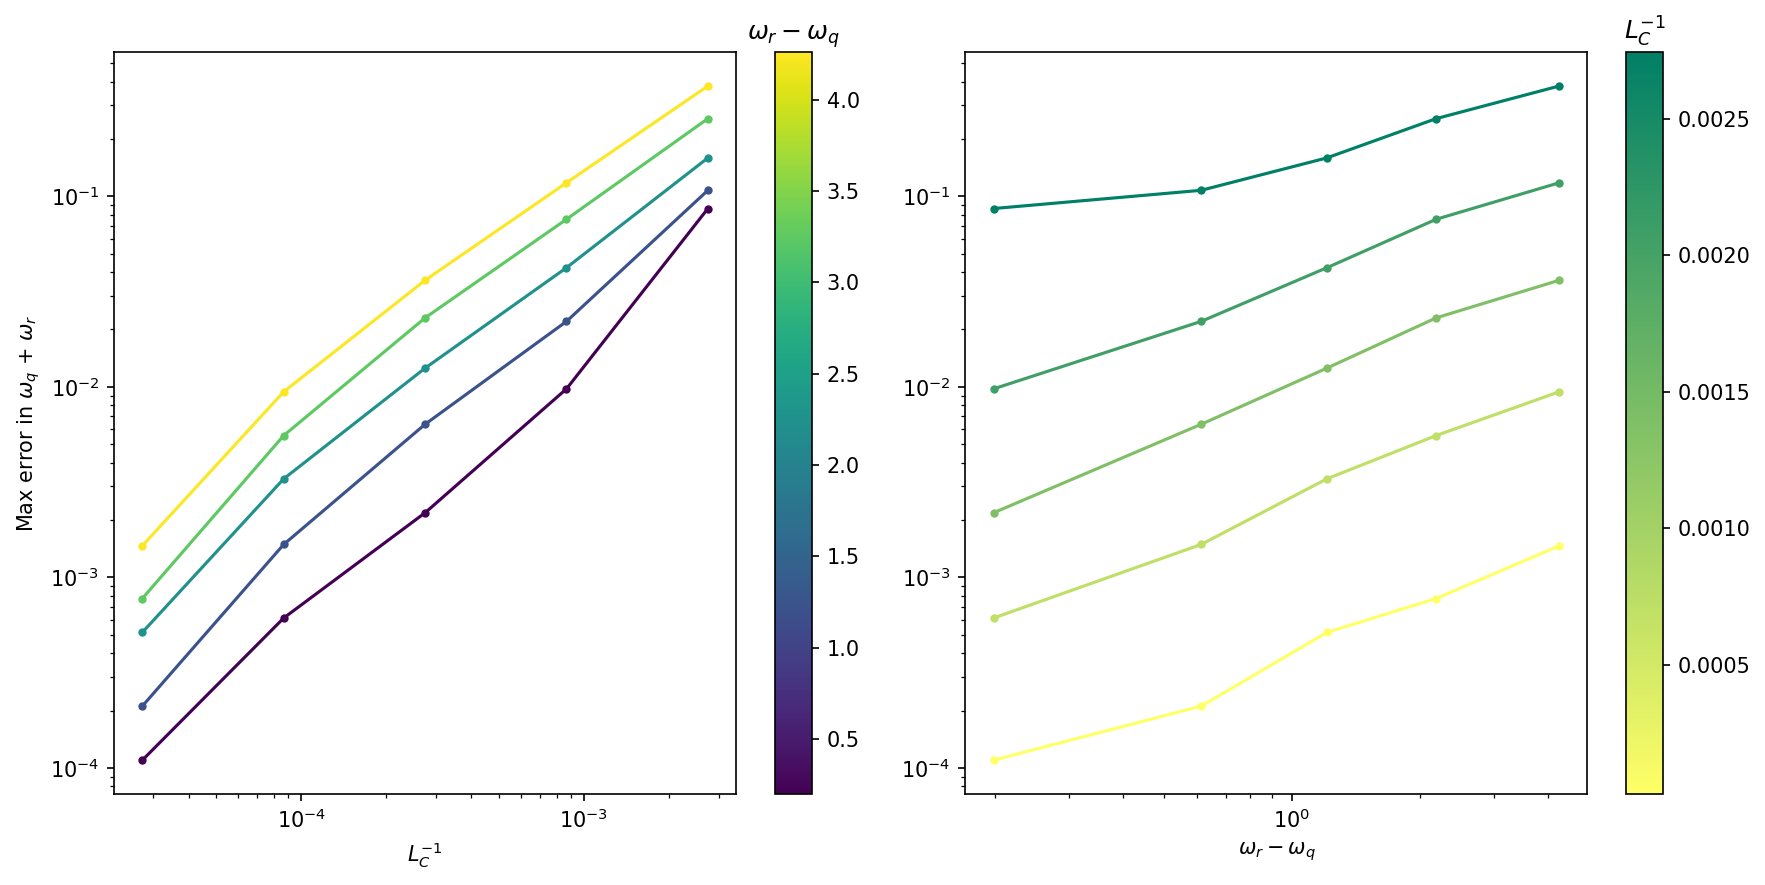

In [107]:
colors_1 = figs.generate_colors_from_colormap(len(C_R_eff_values), 'viridis')
colors_2 = figs.generate_colors_from_colormap(len(L_C_eff_values), 'summer_r')

fig, (ax1, ax2) = plt.subplots(ncols = 2, dpi=150, figsize=[12,6])

for k, C_R_eff_k in enumerate(C_R_eff_values):
    ax1.plot(L_C_eff_values**-1, max_error[k],'.-', color = colors_1[k])

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(r'Max error in $\omega_q$ + $\omega_r$')
ax1.set_xlabel(r'$L_C^{-1}$')

figs.colorbar_for_lines(fig, ax1, α_qr, 'viridis', label='$\omega_r-\omega_q$', location='top' )

for j, L_C_eff_j in enumerate(L_C_eff_values):
    ax2.plot(α_qr, max_error[:,j],'.-', color = colors_2[j])


figs.colorbar_for_lines(fig, ax2, L_C_eff_values**-1, 'summer_r', label='$L_C^{-1}$', location='top' )

ax2.set_xlabel(r'$\omega_r-\omega_q$')
ax2.set_yscale('log')
ax2.set_xscale('log')

fig.tight_layout()

 ## P1

In [108]:
max_error = []
α_qr = np.zeros(len(C_R_eff_values))
for k, C_R_eff_k in enumerate(C_R_eff_values):
    print(k)
    fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5, nmax_f=nmax_f)
    resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff_k, Δ=Δ, nmax_r=nmax_r)
    ω_q = sq_ext.diag(fluxonium_0.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
    ω_r = sq_ext.diag(resonator.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
    α_qr[k] = ω_r-ω_q
    fluxonium_0.diag(3)
    gx_p1_vs_φ_ext, gz_p1_vs_φ_ext, _, _= sq_ext.fluxonium_qubit_ops_vs_φ_ext(EJ, E_0, fluxonium_0, φ_ext_values)
    for j, L_C_eff_j in enumerate(L_C_eff_values):
        g_Φ = sq_ext.get_parameters_QR(fluxonium_0, resonator, L_C_eff_j)
        
        error_vs_φ_ext = np.zeros(len( φ_ext_values  ))
        for i, φ_ext in enumerate(φ_ext_values):
            fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff=L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f)
            H = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff_j )
            E_exact = sq_ext.diag(H, 3, out='GHz', solver='Qutip', qObj=True, remove_ground=True)[0]
            
            coefs = [ω_q, gx_p1_vs_φ_ext[i], gz_p1_vs_φ_ext[i], ω_r, g_Φ]
            error_vs_φ_ext[i] = sq_ext.E_fit_QR_low_ene(coefs, E_exact)
            
        max_error.append(error_vs_φ_ext.max())
    
max_error = np.array(max_error).reshape([len(C_R_eff_values), len(L_C_eff_values)])



0
1
2
3
4


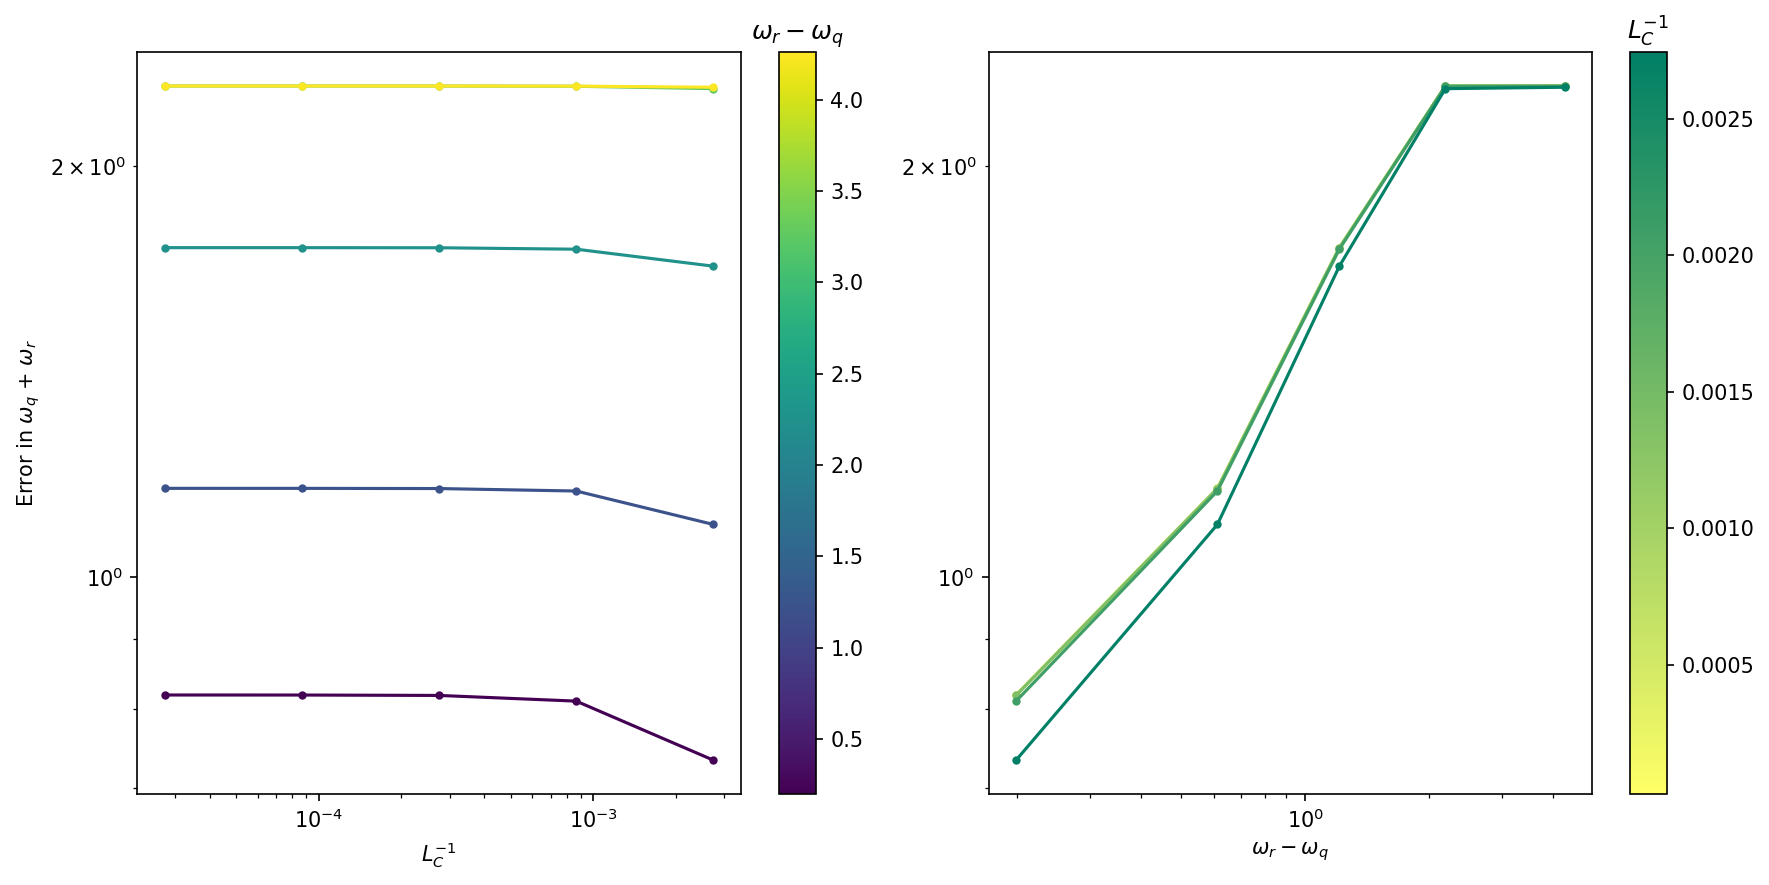

In [109]:
colors_1 = figs.generate_colors_from_colormap(len(C_R_eff_values), 'viridis')
colors_2 = figs.generate_colors_from_colormap(len(L_C_eff_values), 'summer_r')

fig, (ax1, ax2) = plt.subplots(ncols = 2, dpi=150, figsize=[12,6])

for k, C_R_eff_k in enumerate(C_R_eff_values):
    ax1.plot(L_C_eff_values**-1, max_error[k],'.-', color = colors_1[k])

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(r'Error in $\omega_q$ + $\omega_r$')
ax1.set_xlabel(r'$L_C^{-1}$')

figs.colorbar_for_lines(fig, ax1, α_qr, 'viridis', label='$\omega_r-\omega_q$', location='top' )

for j, L_C_eff_j in enumerate(L_C_eff_values):
    ax2.plot(α_qr, max_error[:,j],'.-', color = colors_2[j])


figs.colorbar_for_lines(fig, ax2, L_C_eff_values**-1, 'summer_r', label='$L_C^{-1}$', location='top' )

ax2.set_xlabel(r'$\omega_r-\omega_q$')
ax2.set_yscale('log')
ax2.set_xscale('log')

fig.tight_layout()

 ## P2

In [82]:
max_error = []
α_qr = np.zeros(len(C_R_eff_values))
for k, C_R_eff_k in enumerate(C_R_eff_values):
    print(k)
    fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5, nmax_f=nmax_f)
    resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff_k, Δ=Δ, nmax_r=nmax_r)
    ω_q = sq_ext.diag(fluxonium_0.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
    ω_r = sq_ext.diag(resonator.hamiltonian(), 2, solver='numpy', remove_ground=True)[0][1]
    α_qr[k] = ω_r-ω_q
    fluxonium_0.diag(3)
    gx_p2_vs_φ_ext, gz_p2_vs_φ_ext = sq_ext.fluxonium_qubit_ops_vs_φ_ext(EJ, E_0, fluxonium_0, φ_ext_values, return_full = True)
    for j, L_C_eff_j in enumerate(L_C_eff_values):
        g_Φ = sq_ext.get_parameters_QR(fluxonium_0, resonator, L_C_eff_j)
        
        error_vs_φ_ext = np.zeros(len( φ_ext_values  ))
        for i, φ_ext in enumerate(φ_ext_values):
            fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff=L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f)
            H = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff_j )
            E_exact = sq_ext.diag(H, 3, out='GHz', solver='Qutip', qObj=True, remove_ground=True)[0]
            
            coefs = [ω_q, gx_p2_vs_φ_ext[i], gz_p2_vs_φ_ext[i], ω_r, g_Φ]
            error_vs_φ_ext[i] = sq_ext.E_fit_QR_low_ene(coefs, E_exact)
            
        max_error.append(error_vs_φ_ext.mean())
    
max_error = np.array(max_error).reshape([len(C_R_eff_values), len(L_C_eff_values)])



0
1
2
3
4


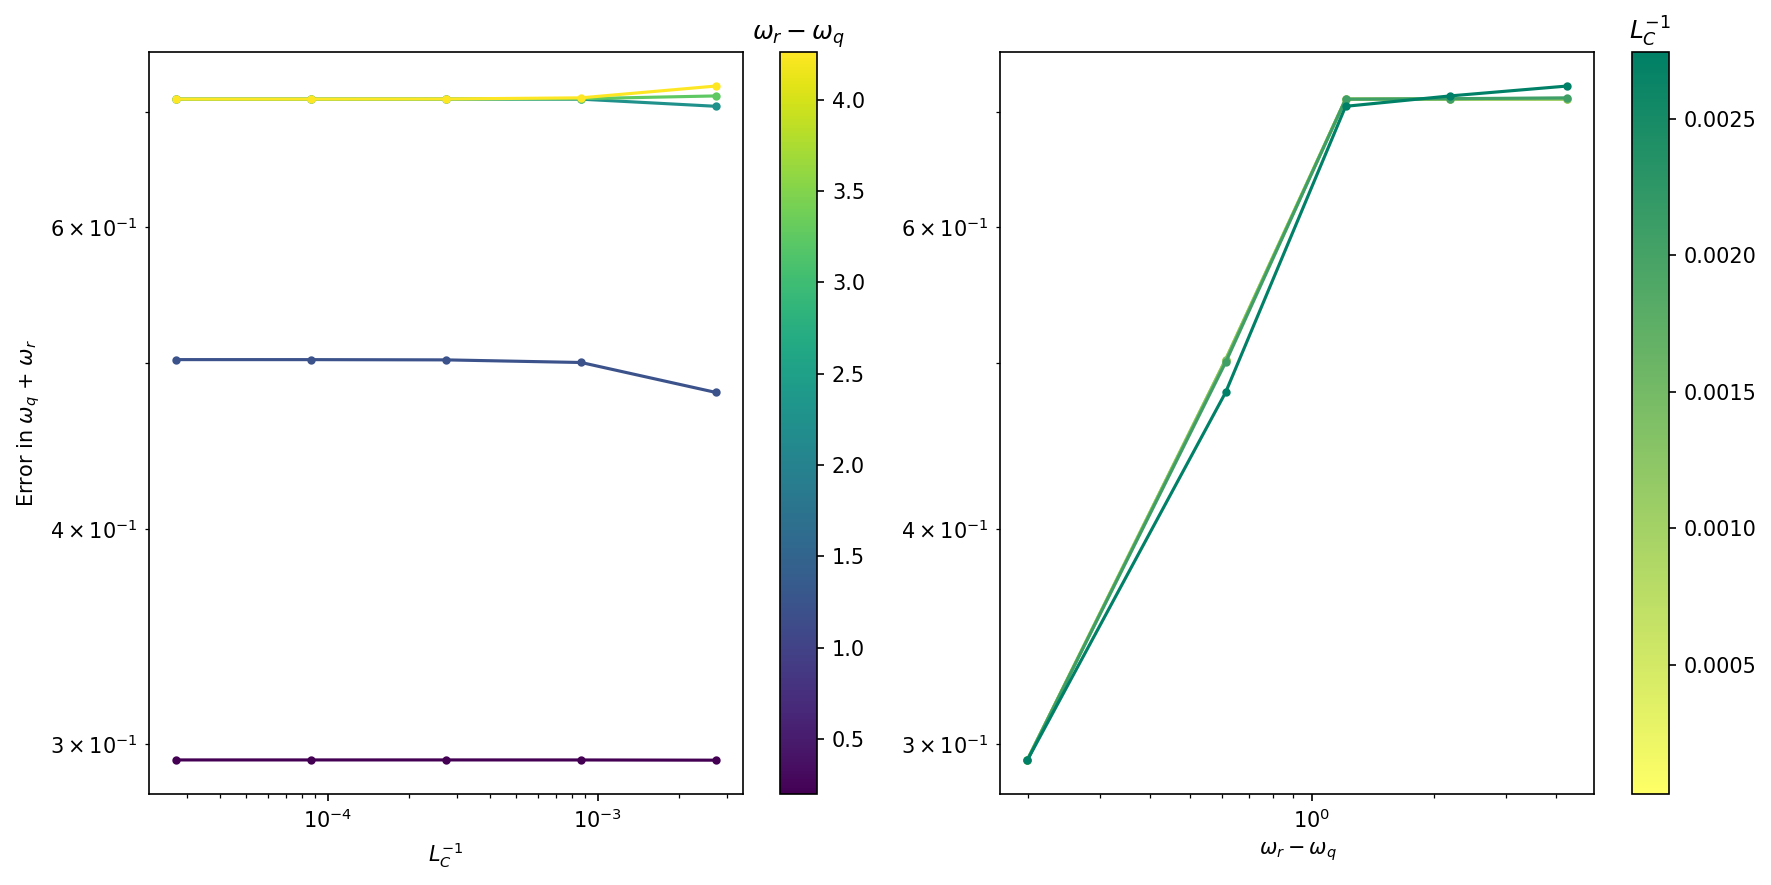

In [83]:
colors_1 = figs.generate_colors_from_colormap(len(C_R_eff_values), 'viridis')
colors_2 = figs.generate_colors_from_colormap(len(L_C_eff_values), 'summer_r')

fig, (ax1, ax2) = plt.subplots(ncols = 2, dpi=150, figsize=[12,6])

for k, C_R_eff_k in enumerate(C_R_eff_values):
    ax1.plot(L_C_eff_values**-1, max_error[k],'.-', color = colors_1[k])

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel(r'Error in $\omega_q$ + $\omega_r$')
ax1.set_xlabel(r'$L_C^{-1}$')

figs.colorbar_for_lines(fig, ax1, α_qr, 'viridis', label='$\omega_r-\omega_q$', location='top' )

for j, L_C_eff_j in enumerate(L_C_eff_values):
    ax2.plot(α_qr, max_error[:,j],'.-', color = colors_2[j])


figs.colorbar_for_lines(fig, ax2, L_C_eff_values**-1, 'summer_r', label='$L_C^{-1}$', location='top' )

ax2.set_xlabel(r'$\omega_r-\omega_q$')
ax2.set_yscale('log')
ax2.set_xscale('log')

fig.tight_layout()